In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from lxml import etree
from tqdm import tqdm
import numpy as np
import pandas as pd
import string
import gensim
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from scipy import stats
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn
from sklearn.manifold import TSNE

In [0]:
map_file = 'gdrive/My Drive/NLP_HW_2/bn2wn_mapping.txt'
mapping = pd.read_fwf(map_file, sep='\t',\
                      header = None, names=['BN_idx'],usecols=[0])
bn_set = set(mapping.BN_idx) # set of babelnet synset ids

In [0]:
file_name = 'gdrive/My Drive/NLP_HW_2/eurosense.v1.0.high-precision.xml'

context = etree.iterparse(file_name, events=("start", "end"), tag='sentence')
# creation of three files: w2v_input_main - all english sentences,
# anchor_bn_dict_main - dictionary of english anchor:bn_syset
# bn_lemma_dict_main - dictionary of english bn_synset:lemma
with open('w2v_input_main.txt', encoding='utf-8', mode='w') as w2v_input_file:
    anchor_bn_file = open('anchor_bn_dict_main.txt', 'w')
    bn_lemma_file = open('bn_lemma_dict_main.txt', 'w')
  
    for event, element in tqdm(context):
        sentence_str = '' # string to save every sentence
        anchor_bn = dict() # dict to save anchor:bn_syset for every sentence
        bn_lemma = dict() # dict to save bn_syset:lemma for every sentence
        
        #elem is a one sentence, take only english translation
        for elem in element.iter():
            if elem.get('lang') == 'en': # lang is attribute
                # elem.text = I do believe that it is vital to minimise the grey
                # areas and emphasise fields for cooperation .
                if elem.tag == 'annotation':
                    if elem.text is None: # if elem is empty
                        continue
                    else: # if elem not empty
                        if elem.text in bn_set: # take only synset from BabelNet set
                            anchor_bn.update({elem.get("anchor"):elem.text})
                            bn_lemma.update({elem.text:elem.get("lemma")})
                elif elem.tag == 'text':
                    if elem.text is None: # if elem is empty
                        continue
                    else: # if elem not empty
                        sentence_str = elem.text

        element.clear()
        if not sentence_str: # if sentence is empty continue
            continue
        else: # if sentence is not empty write lines to file
            anchor_bn_file.write(str(anchor_bn)+'\n')
            bn_lemma_file.write(str(bn_lemma)+'\n')
            w2v_input_file.write(sentence_str)
            w2v_input_file.write('\n')
    # close dict files
    anchor_bn_file.close()
    bn_lemma_file.close()
print('parsing done')

In [0]:
# =============================================================================
# function stopwords_symbols
# =============================================================================
def stopwords_symbols(s_clean):
    '''
    function takes as input string = sentence and returns string = sentence 
    without stopwords and without all the words which len is smaller 
    than 2 characters. also lowers sentence
    '''
    stop_words = set(stopwords.words('english')) # set of english stopwords
    line_tokens = word_tokenize(s_clean.lower()) # split and lowercase of sentence
    filtered_sentence = [] # list of one sentence to save it without stopwords
    for w in line_tokens:
        # deletes stopwords and words with len < 2
        if (w not in stop_words) & (len(w) > 2): 
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

In [0]:
# =============================================================================
# function simple_preprocessing
# =============================================================================
def simple_preprocessing(s_clean):
    '''
    function which takes as input string = sentence and returns same sentence
    in lower case
    '''
    return s_clean.lower()

In [0]:
# =============================================================================
# function lowering_dicts
# =============================================================================
def lowering_dicts(anchor_dict,lemma_dict):
    '''
    function for lowercasing anchors and lemmas in dictionaries
    '''
    anchor_dict_low = dict()
    for k,v in anchor_dict.items():
        anchor_dict_low.update({k.lower(): v.lower()})
    lemma_dict_low = dict()
    for k,v in lemma_dict.items():
        lemma_dict_low.update({k.lower(): v.lower()})
    return (anchor_dict_low, lemma_dict_low)

16425it [00:20, 3007.29it/s]

In [0]:
# =============================================================================
# main function to preprocess each sentence
# =============================================================================
def sentence_formatting(s_clean, anchor_dict, lemma_dict):
    # s_clean = simple_preprocessing(s_clean) # line for simple preprocessing
    s_clean = stopwords_symbols(s_clean) # deleting stopwords from sentence
    anchor_dict, lemma_dict = lowering_dicts(anchor_dict,lemma_dict) # lowercasing dicts
    # if there are anchors or lemmas to substitute in sentence
    if (len(list(anchor_dict.keys())) >= 1) | (len(list(lemma_dict.keys())) >= 1):
        # formatting anchors in dict in the same way as in the sentence for proper replacement
        dict_keys = list(anchor_dict.keys())
        for k in dict_keys:
            k_clean = ' '.join(k.translate(str.maketrans('', '', string.punctuation)).split())
            anchor_dict[k_clean] = anchor_dict.pop(k)
        del dict_keys
        # list of keys of anchor_bn dict
        # sorted to change words in sentence to the longest possible anchors
        s_key = sorted(list(anchor_dict.keys()), key=len, reverse=True)
        sntnc = s_clean
        # changing longest possible words/collocations in sentence firstly to anchors
        # secondly to lemma_synset
        for elem in s_key:
            sntnc = sntnc.replace(elem, anchor_dict[elem])
        for el in list(lemma_dict.keys()):
            sntnc = sntnc.replace(el, '_'.join(['_'.join(lemma_dict[el].split()),el]))
        return sntnc
    else:
        return s_clean

In [0]:
# =============================================================================
# Preprocessing of input file, using anchor/lemma dictionaries
# =============================================================================
# preprocessing w2v_input_main file, which contains sentences from XML file
with open('gdrive/My Drive/NLP_HW_2/w2v_input_main.txt', encoding='utf-8', mode='r') as input_f:
    with open('gdrive/My Drive/NLP_HW_2/anchor_bn_dict_main.txt', encoding='utf-8', mode='r') as anchor_f:
        with open('gdrive/My Drive/NLP_HW_2/bn_lemma_dict_main.txt', encoding='utf-8', mode='r') as lemma_f:
            lines_i = input_f.readlines()
            lines_a = anchor_f.readlines()
            lines_l = lemma_f.readlines()
            # model_input_file - final file for model, where words in sentence
            # are changed to lemma_bnsynset
            model_input_file = open('model_input_file_withoutstopwords.txt','w')
            for s,a,l in tqdm(zip(lines_i,lines_a,lines_l)):
                # reading anchor_dict
                anchor_dict = eval(a)
                # reading lemma_dict
                lemma_dict = eval(l)
                # sentence without punctuation
                s_clean = ' '.join(s.translate(str.maketrans('', '', \
                                                             string.punctuation)).split())
                # calling main function for changing sentence
                file_line = sentence_formatting(s_clean, anchor_dict, lemma_dict)
                # saving changed line into file
                model_input_file.write(str(file_line)+'\n')
            model_input_file.close()

In [0]:
!cp 'model_input_file_withoutstopwords.txt' 'gdrive/My Drive/NLP_HW_2'

In [0]:
# =============================================================================
# Model training
# =============================================================================
embed_size = 400
model = gensim.models.Word2Vec(corpus_file='gdrive/My Drive/NLP_HW_2/model_input_file_withoutstopwords.txt',\
                               size=embed_size, window=10, sample=0.0001, workers=4, hs=1, iter=7)
model.wv.save_word2vec_format('embeddings_full_witout_stopwords.vec', binary=False) #20.05

In [0]:
!cp 'embeddings_full_witout_stopwords.vec' 'gdrive/My Drive/NLP_HW_2'

In [6]:
# =============================================================================
# Cleaning embeddings file to save only sense embeddings
# =============================================================================
zenzez = []
with open('gdrive/My Drive/NLP_HW_2/embeddings_full_witout_stopwords.vec',\
          encoding='utf-8', mode='r') as f:
    for _, line in tqdm(enumerate(f.readlines())):
        if '_bn:' in line.split()[0]:
            zenzez.append(line)
        else:
            continue

with open('embeddings.vec', mode='w') as f:
    f.write('{} 400\n'.format(str(len(zenzez))))
    for zenze in zenzez:
        f.write('{}'.format(str(zenze)))

72363it [00:01, 50794.00it/s]


In [0]:
!cp 'embeddings.vec' 'gdrive/My Drive/NLP_HW_2'

In [0]:
# =============================================================================
# Check that embeddings file was saved right
# =============================================================================
model = KeyedVectors.load_word2vec_format('gdrive/My Drive/NLP_HW_2/embeddings.vec', \
                                          binary=False)

In [11]:
# =============================================================================
#  Computing similarity
# =============================================================================
# vocabulary of sense embeddings
sense_vocab = model.wv.vocab
# computing cosine similarity between gold and received scores
similarity_file = 'gdrive/My Drive/NLP_HW_2/combined.tab' 
with open(similarity_file, encoding='utf-8', mode='r') as f:
    gold_scores = [] # list to save scores from similarity_file
    cos_scores = [] # computed cosine scores
    for line in tqdm(f.readlines()[1:]):
        w1_set = set() # set of senses for word 1
        w2_set = set() # set of senses for word 2
        gold_scores.append(float(line.split()[2])/10)
        w1 = line.split()[0] # word 1
        w2 = line.split()[1] # word 2
        for word in sense_vocab.keys():
            if (word.split('_')[0] == w1):
                w1_set.add(word) # filling set of senses for word 1
        for word in sense_vocab.keys():
            if (word.split('_')[0] == w2):
                w2_set.add(word) # filling set of senses for word 2
        # computing cosine similarity for words 1 and 2
        sc = -1
        if (len(w1_set) > 0) & (len(w2_set) > 0):
            for s1 in list(w1_set):
                for s2 in list(w2_set):
                    sc = max(sc, model.wv.similarity(s1,s2))
            cos_scores.append(sc)
        else:
            sc = -1
            # list of cosine similarity for every pair of words from similarity_file
            cos_scores.append(sc) 

print(stats.spearmanr(gold_scores, cos_scores)) # max acheived value is 0.2496, depends on training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
  0%|          | 0/353 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
100%|██████████| 353/353 [00:10<00:00, 34.73it/s]

SpearmanrResult(correlation=0.2100715035664624, pvalue=6.968595264009579e-05)


In [0]:
# =============================================================================
# Additional word similarity
# =============================================================================
def tanimoto_dist(w1,w2):
    '''
    tanimoto distance for word1 and word1 - vectors
    '''
    tanimoto_coeff = np.dot(w1,w2) / ((np.linalg.norm(w1))**2 + (np.linalg.norm(w2))**2 - np.dot(w1,w2))
    return tanimoto_coeff

def tanimoto_val(word1):
    val_list = []
    w1 = model.wv.word_vec(word1, use_norm=False)
    for elem in sense_vocab.keys():
        w2 = model.wv.word_vec(elem, use_norm=False)
        t_val = tanimoto_dist(w1,w2)
        val_list.append((elem,t_val))
    val_list.sort(key=lambda x: x[1], reverse = True)
    return(val_list[:5])

In [0]:
#  dict for use to show scores of different metrics and visualizations for ambiguous terms
similarity_words_ex = {'bank_bn:00008363n' : 'geo_bank',
                     'bank_bn:00008364n' : 'financial_bank',
                     'number_bn:00058286n' : 'phone_number',
                     'number_bn:00001079n' : 'acting_number'}

In [ ]:
# creation of dataframe with scores of tanimoto distance
for idx, elem in enumerate(similarity_words_ex.keys()):
    if idx == 0:
        df = pd.DataFrame(tanimoto_val(elem), columns=[' '+ similarity_words_ex.get(elem),\
                                                   'T'])
    else:
        df = pd.concat([df, pd.DataFrame(tanimoto_val(elem), \
                                     columns=[' '+ similarity_words_ex.get(elem),\
                                              'T'])], axis=1, join='inner')

# creation of dataframe with scores of cosine distance
for idx, elem in enumerate(similarity_words_ex.keys()):
    if idx == 0:
        df_cos = pd.DataFrame(model.similar_by_word(elem, topn=5), columns=[' '+ similarity_words_ex.get(elem),\
                                                   'Cos'])
    else:
        df_cos = pd.concat([df_cos, pd.DataFrame(model.similar_by_word(elem, topn=5), \
                                     columns=[' '+ similarity_words_ex.get(elem),\
                                              'Cos'])], axis=1, join='inner')

In [16]:
df

geo_bank         T  ...                acting_number         T
0         bank_bn:00008363n  1.000000  ...          number_bn:00001079n  1.000000
1  watercourse_bn:00074588n  0.316380  ...       judgement_bn:00048496n  0.186533
2         flow_bn:00085894v  0.308399  ...           libel_bn:00050934n  0.185659
3      moselle_bn:00055972n  0.262554  ...  special_report_bn:00035056n  0.179710
4        river_bn:00067948n  0.253674  ...  position_paper_bn:00002160n  0.170523

[5 rows x 8 columns]

In [17]:
df_cos

geo_bank       Cos  ...                acting_number       Cos
0        river_bn:00067948n  0.518511  ...       judgement_bn:00048496n  0.365150
1  watercourse_bn:00074588n  0.480953  ...           libel_bn:00050934n  0.316021
2         oder_bn:00058637n  0.477325  ...       convinced_bn:00100431a  0.312966
3         flow_bn:00085894v  0.471819  ...  special_report_bn:00035056n  0.306120
4         lake_bn:00049709n  0.467138  ...           hurry_bn:00088134v  0.304725

[5 rows x 8 columns]

In [18]:
# =============================================================================
# Computing similarity using tanimoto metric
# =============================================================================
similarity_file = 'gdrive/My Drive/NLP_HW_2/combined.tab' 
with open(similarity_file, encoding='utf-8', mode='r') as f:
    gold_scores = []
    t_scores = []
    for line in tqdm(f.readlines()[1:]):
        w1_set = set()
        w2_set = set()
        gold_scores.append(float(line.split()[2])/10)
        w1 = line.split()[0]
        w2 = line.split()[1]
        for word in sense_vocab.keys():
            if (word.split('_')[0] == w1):
                w1_set.add(word)
        for word in sense_vocab.keys():
            if (word.split('_')[0] == w2):
                w2_set.add(word)
        # similarity
        if (len(w1_set) > 0) & (len(w2_set) > 0):
            sc = 0
            for s1 in list(w1_set):
                w1 = model.wv.word_vec(s1, use_norm=False)
                for s2 in list(w2_set):
                    w2 = model.wv.word_vec(s2, use_norm=False)
                    sc = max(sc, tanimoto_dist(w1,w2))
            t_scores.append(sc)
        else:
            sc = 0
            t_scores.append(sc)
print(stats.spearmanr(gold_scores, t_scores))

  0%|          | 0/353 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
100%|██████████| 353/353 [00:09<00:00, 37.57it/s]

SpearmanrResult(correlation=0.1947313081526875, pvalue=0.0002323294402215201)


In [0]:
# =============================================================================
# Plots
# =============================================================================
# cosine distance list
cos_voc_gr_bank = list(similarity_words_ex.keys())[:2] + list(df_cos[' geo_bank']) + \
list(df_cos[' financial_bank'])
cos_voc_gr_bank_number = list(similarity_words_ex.keys())[2:] + \
list(df_cos[' phone_number']) + list(df_cos[' acting_number'])

# tanimoto distance list
tanimoto_voc_gr_bank = list(df[' geo_bank']) + list(df[' financial_bank'])
tanimoto_voc_gr_number = list(df[' phone_number']) + list(df[' acting_number'])

In [0]:
def tsne_plot(l_voc):
    '''
    visualization of a examples of the embeddings with t-SNE
    '''
    labels = []
    tokens = []

    for word in l_voc:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(n_components=2, perplexity=5, early_exaggeration=6.0, init='pca', \
                      learning_rate = 200, n_iter=2500, metric = 'euclidean', random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12, 7)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    return plt.show()

In [21]:
tsne_plot(tanimoto_voc_gr_bank)

In [22]:
tsne_plot(tanimoto_voc_gr_number)

In [23]:
tsne_plot(cos_voc_gr_bank)

In [24]:
tsne_plot(cos_voc_gr_bank_number)

In [25]:
# data for received by gridsearch for data, cleaned from stopwords
data = pd.read_csv('without_stopwords.csv', sep=';') 
seaborn.relplot(x="iter", y='spearman', col="sample", data=data[['iter','spearman','sample']])

In [26]:
data

size  window  workers  sg  hs   sample  iter  spearman
0    400      10        4   0   1  0.00100     5  0.165732
1    400      10        4   0   1  0.00100     7  0.202134
2    400      10        4   0   1  0.00100     8  0.196145
3    400      10        4   0   1  0.00100    15  0.204107
4    400      10        4   0   1  0.00010     5  0.207363
5    400      10        4   0   1  0.00010     7  0.249608
6    400      10        4   0   1  0.00010     8  0.217185
7    400      10        4   0   1  0.00010    15  0.215559
8    400      10        4   0   1  0.00001     5  0.156713
9    400      10        4   0   1  0.00001     7  0.189725
10   400      10        4   0   1  0.00001     8  0.175312
11   400      10        4   0   1  0.00001    15  0.167722

In [0]:
# full grid search
data_full = pd.read_csv('full_grid.csv', sep=';')

In [28]:
data_full

size  window  workers  sg  hs   sample  iter  no_stopwords  spearman
0    400      10        4   0   0  0.00100     7             0  0.165732
1    400      10        4   0   0  0.00100     7             0  0.153039
2    400      10        4   0   0  0.00100    30             0  0.201429
3    400      10        4   0   0  0.00100    50             0  0.211562
4    400      10        4   0   1  0.00100    15             0  0.142413
5    400      10        4   0   1  0.00100    30             0  0.157592
6    400      10        4   0   1  0.00010     7             0  0.201836
7    400      10        4   0   1  0.00010    15             0  0.213271
8    400      10        4   0   1  0.00100     5             1  0.165732
9    400      10        4   0   1  0.00100     7             1  0.202134
10   400      10        4   0   1  0.00100     8             1  0.196145
11   400      10        4   0   1  0.00100    15             1  0.204107
12   400      10        4   0   1  0.00010     5             1  0.207363
13   400      10        4   0   1  0.00010     7             1  0.249608
14   400      10        4   0   1  0.00010     8             1  0.217185
15   400      10        4   0   1  0.00010    15             1  0.215559
16   400      10        4   0   1  0.00001     5             1  0.156713
17   400      10        4   0   1  0.00001     7             1  0.189725
18   400      10        4   0   1  0.00001     8             1  0.175312
19   400      10        4   0   1  0.00001    15             1  0.167722
20   400      10        4   0   1  0.00010     7             1  0.249608
21   400      10        4   0   1  0.00010     8             1  0.217185
22   400      10        4   0   1  0.00010    15             1  0.215559
23   400      10        4   0   1  0.00010    30             1  0.205118

1903116it [00:02, 800596.39it/s]


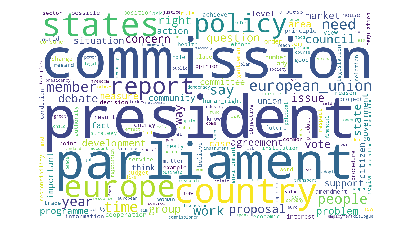

In [29]:
# =============================================================================
# Plot for most frequent sense_embeddings in corpus
# =============================================================================
def get_freq_words(file):
    vec = CountVectorizer().fit(file)
    bag_of_words = vec.transform(file)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

model_input_file = [line.replace("\n", "") for line in tqdm(open("gdrive/My Drive/NLP_HW_2/model_input_file_withoutstopwords.txt"))]
freq_words = get_freq_words(model_input_file)

freq_senses = []
for elem in freq_words:
    if (elem[0][-3:] == '_bn') & (len(elem[0]) > 3):
        freq_senses.append((elem[0][:-3],elem[1]))  
    
wordcloud = WordCloud(width=1600, height=1000, background_color='white', relative_scaling=.8).generate_from_frequencies(dict(freq_senses))
wordcloud.to_file("cloud.png")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()